# Contents
### 1. <a href='#Introduction'>Introduction</a>
### 2.<a href='#mbias'>Measures for Bias-Evaluation</a> 
#### $\qquad $<a href='#mtop'>Measures based on Top-K results</a>
#### $\qquad \qquad$ <a href='#skew'>Skew@k</a>
#### $\qquad \qquad$<a href='#minskew'> MinSkew@k</a>
#### $\qquad \qquad$<a href='#maxskew'> MaxSkew@k</a>
#### $\qquad $<a href='#rmes'>Rankning Measures</a>
#### $\qquad \qquad$<a href='#ndkl'>NDKL</a>
#### $\qquad \qquad$<a href='#ndcg'>NDCG</a>
### 3.<a href='#desprop'>Desired Properties</a> 
#### $\qquad $<a href='#infs'>Infeasible Index and Infeasible Count</a>
### 4.<a href='#algos'>(Re)Ranking Algorithms</a> 
#### $\qquad $<a href='#vanilla'>Vanilla-Baseline</a>
#### $\qquad $<a href='#algo1'>Algorithm 1 : DetGreedy</a>
#### $\qquad $<a href='#algo2'>Algorithm 2 : DetCons</a>
#### $\qquad $<a href='#algo3'>Algorithm 3 : DetRelaxed</a>
#### $\qquad $<a href='#algo4'>Algorithm 4 : DetConstSort</a>
### 5.<a href='#exe'>Executing the Re-Ranking Algorithms</a> 
#### $\qquad $<a href='#metrics'>Computing Metrics</a>
#### $\qquad $<a href='#results'>Plotting Results</a>

# <a id='Introduction'>Introduction</a>

## Reference paper:
The following work is an implementation of the "Fairness-Aware Ranking in Search & Recommendation Systems with Application to LinkedIn Talent Search" link : https://dl.acm.org/doi/10.1145/3292500.3330691

Ranked lists generated by recommendation systems have been becoming computationally efficient, yet there is a growing need to ensure they are free from algorithmic bias. Such biased results can lead to systematic discrimination, reduce visibility, cause over/under representation and be the reason for gender and other forms of bias. In the code that follows, such bias is quantified and mitigated via fairness-aware re-ranking algorithms. For a given search query, these algorithms can generate a desired distribution (over protected attribute(s)) of top ranked results, thereby maintaining demographic parity or equal opportunity as per requirement. Metrics are defined to assess the fairness thus achieved and results over a synthetically generated data are shown.

### <a id='Libraries'>Libraries</a>

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# <a id='mbias'>Measures for Bias-Evaluation</a>

The below notations shall be used in the equations tha follow (adapted from the paper)

$$\begin{array}{c|l}
\hline \hline \text { Notation } & \text { Represents } \\
\hline \hline r & \text { A search request or a recommendation task } \\
\hline A=\left\{a_{1}, \ldots, a_{l}\right\} & \begin{array}{l}
\text { Set of disjoint protected attribute values (each } \\
\text { candidate has exactly one value in } A \text { ); Note that } \\
\text { we denote the attribute value for candidate } x \text { as } \\
A(x), \text { by abuse of notation. }
\end{array} \\
\hline \tau_{r} & \begin{array}{l}
\text { Ranked list of candidates for } r ; \tau_{r}[j] \text { denotes } j^{t h} \\
\text { candidate; } \tau_{r}^{k} \text { denotes the first } k \text { candidates in } \tau_{r}
\end{array} \\
\hline p_{q, r, a_{i}} & \begin{array}{l}
\text { Desired proportion of candidates with attribute } \\
\text { value } a_{i} \text { that should be in the ranked list }
\end{array} \\
\hline p_{\tau_{r}, r, a_{i}} & \begin{array}{l}
\text { Proportion of candidates in } \tau_{r} \text { with value } a_{i}, \text { i.e., } \\
\frac{\left\{x \in \tau_{r} | A(x)=a_{i}\right\}}{\left|\tau_{r}\right|}
\end{array} \\
\hline \hline
\end{array}$$

### <a id='mtop'>Measure Based on Top-k Results</a>

#### <a id='skew'>Skew@k</a>

The deviation of the top k ranked results from the desired proportion is quantified using a skew metric. The log function gives a negative skewness value for under representation and a positive skewness value for over represenation of the particular protected attribute class. 

$$
\operatorname{Skew}_{a_{i}} @ k\left(\tau_{r}\right)=\log _{e}\left(\frac{p_{\tau_{r}^{k}, r, a_{i}}}{p_{q, r, a_{i}}}\right)
$$


In [2]:
def proportion(df,k,ai):
    count=0
    for i in range(k):  
        if (df[i] == ai): 
            count = count+1
    return (count/k)    

def Skew(df,p,k,ai):
    s = math.log((proportion(df,k,ai)+1)/(p[ai]+1)) 
    return s 

The above metric, however intuitive it may be, is only defined over a single attribute value and needs to be extended over all protected attribute classes. Also, the computed value largely depends on the k value and hence a cumulative and comprehensive metric is required.

To address the first issue, MinSkew and MaxSkew metrics are defined. MinSkew quantifies the worst disadvantage and MaxSkew the largest unfair advantage for a candidate with a given attribute value.

#### <a id='minskew'>MinSkew@k</a>
For a search request $r,$ MinSkew@k provides the minimum skew among all attribute values

$$\operatorname{MinSkew} @ k\left(\tau_{r}\right)=\min _{a_{i} \in A} \operatorname{Skew}_{a_{i}} @ k\left(\tau_{r}\right)$$

In [3]:
def MinSkew(df,p,k):
    min_skew=float('inf')
    for x in range(len(p)):
        m=Skew(list(df),p,k,x)
        if m < min_skew:
            min_skew = m
    return min_skew

#### <a id='maxskew'>MaxSkew@k</a>
For a search request $r,$ MaxSkew@k provides the maximum skew among all attribute values

$$
\operatorname{MaxSkew} @ k\left(\tau_{r}\right)=\max _{a_{i} \in A} \operatorname{Skew}_{a_{i}} @ k\left(\tau_{r}\right)
$$

In [4]:
def MaxSkew(df,p,k):
    max_skew=-float('inf')
    for x in range(len(p)):
        m=Skew(list(df),p,k,x)
        if m > max_skew:
            max_skew = m
    return max_skew

Since both $\sum p_{\tau_{r}^{k}, r, a_{i}}=1$ and $\sum p_{q, r, a_{i}}=1$, it follows that for any
ranked list, and for any k, MinSkew@k ≤ 0 and MaxSkew@k ≥ 0.

The second issue is resolved by the metrics presented below.

### <a id='rmes'>Ranking Measures</a> 

#### <a id='ndkl'>NDKL</a> 

The Kullback-Leibler (KL) divergence is a non-negative measure whose larger value denotes greater divergence between the distributions. Its a cumulative measure involving weighted average of Skew@i over all attribute values.

Given a ranked list $\tau_r$ of candidates for a search request $r$, the normalized discounted cumulative KL-divergence (NDKL) of $\tau_r$ is

$$N D K L\left(\tau_{r}\right)=\frac{1}{Z} \sum_{i=1}^{\left|\tau_{r}\right|} \frac{1}{\log {2}(i+1)} d{K L}\left(D_{\tau_{r}^{i}} \| D_{r}\right)$$

where, $$d_{K L}\left(D_{1} \| D_{2}\right)=\sum_{j} D_{1}(j) \log {e} \frac{D{1}(j)}{D_{2}(j)}$$ is the KL-divergence of
distribution $D_{1}$ with respect to distribution $D_{2}$ and $Z=\sum_{i=1}^{\left|\tau_{r}\right|} \frac{1}{\log _{2}(i+1)}$.

Bias of equal magnitude but in opposite directions cannot be distiguished by this measure. Hence, it doesn't convey which attribute is unfairly treated.


#### NOTE:
It measures how nicely the desired ranking is "embedded" in the rank list, as it compares the distribution of top$-i$ ranking in $\tau_r$, i.e. $\tau_r^i$ and the distribution of overall ranking $\tau_r$. The $i$th term in sum, vanishes if the distribution $D_{\tau_r^i}=D_r$

In [5]:
def KLD(D1,D2): #When k= |D1|=|D2|, it's the popular KLD
    #return sum(D1[j] * math.log((D1[j]+0.00001)/(D2[j]+0.00001)) for j in range(len(D2)))
    a = np.asarray(D1, dtype=np.float)
    b = np.asarray(D2, dtype=np.float)

    return np.sum(np.where(a != 0 , a * np.log((a +0.00001)/(b+0.00001)), 0))

def NDKL(df,p):
    #Z = sum(1/math.log2(j+1) for j in range(1,len(df)+1))
    Z = np.sum(1/(np.log2(np.arange(1,len(df)+1)+1)))
    total=0

    for i in range(1,len(df)+1): 
        value=df[:i].value_counts(normalize = True)
        value=value.to_dict()
        D1=[]
        for i in range(len(p)):
            if i in value.keys():
                D1.append(value[i])
            else:
                D1.append(0)
        #D1=value.sort_index().to_numpy()
        #D1=np.pad(D1, (0,len(p)-len(D1)), 'constant')
        total=total+(1/math.log2(i+1)) * KLD(D1,p)

    return (1/Z)*total

#### <a id='ndcg'>NDCG</a> 
Normalized Discounted Cumulative Gain is defined over a ranked list of candidates $\tau_{r}$ as follows:

$$\operatorname{NDCG}\left(\tau_{r}\right)=\frac{1}{Z} \sum_{i=1}^{\left|\tau_{r}\right|} \frac{u\left(\tau_{r}[i]\right)}{\log (i+1)},$$ where $u\left(\tau_{r}[i]\right)$ is the relevance for the candidate in
$i^{t h}$ position of $\tau_{r} .$ $Z$ is the normalizing factor corresponding to the discounted cumulative gain for the best possible ranking $\tau_{r}^{}$ of candidates, i.e., $Z=\sum_{i=1}^{\left|\tau_{r}^{}\right|} \frac{u\left(\tau_{r}^{*}[i]\right)}{\log (i+1)}$.

#### NOTE:
1) In our simulations, we treat the score of each candidate as the relevance.

2) Depending on the notion of the "relevance", cumulative gain captures that the very relevant results are more useful than somewhat relevant results which are furthermore useful than irrelevant results.

In [6]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0

def ndcg_at_k(df, k, method=0):
    r=list(df)
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


# <a id='desprop'>Desired Properties</a> 

The representation criteria over top-k results for all $1 \leq k \leq\left|\tau_{r}\right|$ needs to be satisfied as a later ranking of the candidate would certainly be a disadvantage.

The ranked list needs to follow some desirable properties:

$\forall k \leq\left|\tau_{r}\right| \& \forall a_{i} \in A,$ count $_{k}\left(a_{i}\right) \leq\left\lceil p_{a_{i}} \cdot k\right\rceil,$ and,
$
\forall k \leq\left|\tau_{r}\right| \& \forall a_{i} \in A, \text { count }_{k}\left(a_{i}\right) \geq\left\lfloor p_{a_{i}} \cdot k\right\rfloor
$
where $\text { count }_{k}\left(a_{i}\right) $ denotes the number of candidates with attribute value ai among the top k results. 

Note that as sum of proportions is unity, an over-representation of one class implies under-representation of another. Hence we need to ensure minimum representation of each protected attribute class as per the desired distribution

To this extent, two measures are defined to quantify an deviation of these representation criteria.

#### <a id='infs'>Infeasible Index and Infeasible Count</a> 
An algorithm is infeasible if: $\exists r$ s.t. $\exists k \leq\left|\tau_{r}\right| \& a_{i} \in A,$ count $_{k}\left(a_{i}\right)<\left\lfloor p_{a_{i}} \cdot k\right\rfloor$

That there exists atleast one search request which breaks the count condition for some (top) k.

The number of indices for which the minimum representation criteria is violated is given by:
$$
\text { InfeasibleIndex }_{\tau_{r}}=\sum_{k \leq\left|\tau_{r}\right|} 1\left(\exists a_{l} \in A, s . t . \text { count }_{k}\left(a_{l}\right)<\left\lfloor p_{a_{l}} \cdot k J\right)\right.
$$

The number of attribute of attribute values (at every k) for which the minimum representation criteria is violated is given by:
$$
\text { Infeasiblecount }_{\tau_{r}}=\sum_{k \leq\left|\tau_{r}\right|} \sum_{a_{t} \in A} 1\left(\operatorname{count}_{k}\left(a_{i}\right)<\left[p_{a_{l}} \cdot k\right]\right)
$$

The size of the ranked list and the cardinality of the protected attribute affect the above metrics but this can be normalized.

In [7]:
def infeasibleIndex(df,p):
    
    """ Params: df = dataFrame for Ranked List, a= No of Values of Protected Attribute
                desired_p = desired proportion of ai's (Array){Provisioned for Later Modification}
                k initial value need to set(default=10)
    
    """
    
    data = df[:100]
    a=len(p)
    desired_p = p
    tao_r = 100
    infeasibleFlag = False
    InfIndex_tao_r = 0
    InfCount_tao_r = 0
    
    
    for k in range(1,tao_r):
        data_temp_k = data[:k]
        infeasibleFlag = False
        for i in range(a):
            desired_p_ai = desired_p[i]
            observed_count_ai = len(data_temp_k[data_temp_k['ai']==i])
            desired_count_ai= math.floor(desired_p_ai*k)
            if observed_count_ai < desired_count_ai:
                infeasibleFlag = True
                ## Increment Infeasible Count
                InfCount_tao_r += 1
                
        ## Increment Infeasible Index
        if infeasibleFlag == True:
            InfIndex_tao_r += 1
    if InfIndex_tao_r > 99:
        print(f'stop!! at {a} and it is {InfIndex_tao_r}')
    Infeasible_Return_array = [InfIndex_tao_r, InfCount_tao_r]
    return Infeasible_Return_array
    

# <a id='algos'>(Re)Ranking Algorithms</a>

### <a id='vanilla'>Base Line Algorithm with no Mitigation (Vanilla) / Simulation framework for data generation </a>

Some Call for generating Basic Ranking Data can be made. This would serve as the initial baseline upon which re-ranking algorithms would mitigate the bias. Usually this is an ML model but here a simulation framework prescribed by the authors is used to replicate similar results.

In [8]:
class experiment:
    """ 
    This is the simulation framework for generating the data required to run the algorithms.
    It takes in the following variables as user inputs :-
    'max_a' = Maximum cardinality of protected class for which we want to generate synthetic data
    'tasks' = Number of desired probability distributions hypothesized as different queries
    'distribution' = Type of distribution to generate data from. Default-'Uniform'
    'doctrine' = The Doctrine of Fairness to be ensured. Default- 'DI'
    'datapoints' = The number of synthetic Scores to generate for different 'ai' values
    """
    
    def __init__(self,max_a,tasks,rep,distribution,doctrine):
        self.max_a=max_a
        self.tasks=tasks
        self.rep=rep
        self.distribution=distribution
        self.doctrine=doctrine
        self.datapoints=100
        #a=max_a
    
    def setup(self):
        P = {}
        self.data={}
        for a in range (2,self.max_a):
            P[f'a={a}']=self.get_tasks(a)
            for i in P[f'a={a}']:
                for j in range(self.rep): 
                    self.data[(f'a={a}',i,j)] = self.gen_data(a)
        return P

    def get_tasks(self,a):
        T={}
        for i in range(self.tasks):
            T[i]=self.get_distribution(a)
        return T

    def get_distribution(self,a):
        d=[]
        for i in range(a):
            d.append(np.random.uniform())
        d_norm = [float(i)/sum(d) for i in d]
        return d_norm

    def gen_data(self,a):
        scores={}
        scoresgen=[]
        for i in range(a):
            for j in range(self.datapoints):
                scoresgen.append(np.random.uniform())
            scoresgen.sort(reverse=True)
            for j in range(self.datapoints):
                scores[(i,j)]=scoresgen[j]
        #scores_sorted = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1],reverse=True)}
        return scores
    
    def get_value(self,a,i,j):
        return self.data[(f'a={a}',i,j)]

The inputs to the re-ranking algorithms are as follows:

$a:$ Possible attribute values indexed as $a_{i},$ with each attribute value having $n$ candidates with scores $s_{a_{i}}, . .$ Candidate list for each attribute value is assumed to be ordered by decreasing scores, i.e., for $j \geq 0, a_{i, j}$ refers to $j^{t h}$ element of attribute value $a_{i},$ with score $s_{a_{i}, j}$ $\forall k, l: 0 \leq k \leq l \Longleftrightarrow s_{a_{i}, k} \geq s_{a_{i}, l}$

$\boldsymbol{p}:$ A categorical distribution where $p a_{i}$ indicates the desired proportion of candidates with attribute value $a_{i}$

$k_{\max }:$ Number of desired results

The ouput is an ordered list of attribute value ids and scores

## <a id='algo1'>Algorithm 1 : Score Maximizing Greedy Mitigation Algorithm (DetGreedy) </a>

Deterministic Greedy (DetGreedy) algorithm is as follows:

$ \forall a_i $ If minimum constraint is going to be violated, choose one with the next highest score else choose the one with the next highest score among those that have not yet met their maximum representation requirements. Note that the re-ranked list generated by this algorithm might easily fall into infeasible state as it intends to maximize the scores of each protected attribute class.

In [9]:
def DetGreedy(data,p,k_max):
    #a_i=data['i'].unique()
    rankedAttList = [] 
    rankedScoreList = []
    counts={}
    for i in range(len(p)):
        counts[i]=0
    for k in range(1,k_max+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        #print(belowMin)
        if len(belowMin) != 0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
                #s[i]=data['Score'][data.index[data['i']==i and data['j']==counts[i]]]
            nextAtt = max(s,key=s.get)
        else:
            for i in belowMax:
                s[i]=data[(i,counts[i])]
                #s[i]=data['Score'][data.index[data['i']==i and data['j']==counts[i]+1]]
            nextAtt = max(s,key=s.get)
        rankedAttList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        #rankedScoreList.append(data['Score'][data['i']==nextAtt and data['j']==counts[nextAtt]] )  
        counts[nextAtt]+=1
    return pd.DataFrame(list(zip(rankedAttList, rankedScoreList)),columns =['ai', 'score']) 

## <a id='algo2'>Algorithm 2 : Score Maximizing Greedy Conservative Mitigation Algorithm (DetCons)</a>

The Deterministic Conservative (DetCons) is as follows:

To mitigate infeasibility, prefer ai that are likely to violate the min representation soon enough in the ranking. We choose a value that minimizes $\frac{\left\lceil p_{a_{i}} \cdot k\right\rceil}{p_{a_{i}}}$ (the fractional value that doesn't satisy the minimum representation condition).

In [10]:
def DetCons(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        #print(belowMax,belowMin)
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            s={}
            for i in belowMax:
                s[i]=math.ceil(i*p[i])/p[i]
                
            nextAtt= min(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    #return [rankedAttrList,rankedScoreList]
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

## <a id='algo3'>Algorithm 3 :  Conservative Mitigation Algorithm- Relaxed Variant (DetRelaxed)</a>

The Deterministic Relaxed (DetRelaxed) algorithm is as follows:

All attribute values that minimize $\left\lceil\frac{\left\lceil p_{a_{i}} \cdot k\right\rceil}{p_{a_{i}}}\right\rceil$ are shortlisted while selecting the next person with the highest score.

In [11]:
def DetRelax(data,p,kmax):

    rankedAttrList=[]
    rankedScoreList=[]
    counts={}
    for i in range(len(p)):
        counts[i]=0
    
    for k in range(1,kmax+1):
        belowMin = {ai for ai,v in counts.items() if v < math.floor(k*p[ai]) }
        belowMax = {ai for ai,v in counts.items() if v >= math.floor(k*p[ai]) and v <math.ceil(k*p[ai]) }
        s={}
        #print(belowMax,belowMin)
        if len(belowMin)!=0:
            for i in belowMin:
                s[i]=data[(i,counts[i])]
            nextAtt= max(s,key=s.get)
                
        else: 
            ns={}
            for i in belowMax:
                ns[i]=math.ceil(math.ceil(i*p[i])/p[i])
            temp = min(ns.values()) 
            nextAttSet = [key for key in ns if ns[key] == temp] 
            for i in nextAttSet:
                s[i]=data[(i,counts[i])]
            
            nextAtt= max(s,key=s.get)
                
        rankedAttrList.append(nextAtt)
        rankedScoreList.append(data[(nextAtt,counts[nextAtt])])
        counts[nextAtt]+=1
        
    #return [rankedAttrList,rankedScoreList]
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

While DetGreedy is infeasible in cases, we can't certain assert that DetCons and DetRelaxed wont be infeasible. Hence the following algorithm is proposed.

## <a id='algo4'>Algorithm 4 : Feasible Mitigation Algorithm Based on Interval Constarined Sorting (DetConstSort)</a>

The deterministic Constrained Sorting (DetConstSort) algorithms is as follows:

1. For protected attribute keep a counter that increments when atleast one of the classes satisfies its minimum representation criterion and arrange the classes in descending order of score of their next candidate.

2. For each member of this list insert the next candidate from the attribute value to the next empty index in the recommendation list and swap this candidate towards earlier indices in the list until the score of the left candidate (candidate in the earlier index) is larger, or, the Maximum index of the left candidate will be violated due to the swap (maximum index of a candidate is the maximum index (position) in the ranking where the candidate from this attribute value can be placed at so that we meet the condition of feasibility, i.e., $\operatorname{count}_{k}\left(a_{i}\right) \geq\left\lfloor p a_{i} \cdot k\right\rfloor$

In [12]:
def swap(dict, pos1, pos2): 
    dict[pos1], dict[pos2] = dict[pos2], dict[pos1] 
    return dict

def DetConstSort(data,p,kmax):

    rankedAttrDict={}
    rankedScoreDict={}
    maxIndicesDict={}
    
    counts={}
    minCounts={}
    tempMinCounts={}

    lastEmpty=0
    k=0
    
    
    for i in range(len(p)):
        counts[i]=0
        minCounts[i]=0
       #tempMinCounts[i]=0
    
    while lastEmpty<kmax:
        k+=1
       #changedMins=set()
        for j in range(len(p)):
            tempMinCounts[j]=math.floor(k*p[j])
           #if minCounts[j]<tempMinCounts[j]:
               #changedMins.add(j)
        
        changedMins={ai for ai,s in minCounts.items() if s<tempMinCounts[ai]}
        #print(changedMins)
        if len(changedMins) != 0:
            vals={}
            for ai in changedMins:
                vals[ai]=data[(ai,counts[ai])]
            ordChangedMins=np.asarray((sorted(vals.items(),
                                              key = lambda kv:(kv[1], kv[0]),reverse=True)))[:,0].tolist()
            #print(ordChangedMins)
            for ai in ordChangedMins:
                rankedAttrDict[lastEmpty]=ai
                rankedScoreDict[lastEmpty]=data[(ai,counts[ai])]
                maxIndicesDict[lastEmpty]=k
                start=lastEmpty
                
                while start>0 and maxIndicesDict[start-1]>=maxIndicesDict[start] and rankedScoreDict[start-1]<rankedScoreDict[start]:
                    swap(maxIndicesDict,start-1,start)
                    swap(rankedAttrDict,start-1,start)
                    swap(rankedScoreDict,start-1,start)
                    start-=1
                counts[ai]+=1
                lastEmpty+=1
            minCounts=tempMinCounts.copy()

    rankedAttrList=[ v for v in rankedAttrDict.values() ]
    rankedScoreList=[ v for v in rankedScoreDict.values() ]
    return pd.DataFrame(list(zip(rankedAttrList, rankedScoreList)),columns =['ai', 'score'])

# <a id='exe'>Executing the Re-Ranking Algorithms</a>

In [13]:
%%time

demo = experiment(10,10,10,'uniform','DI')
P = demo.setup()

Wall time: 869 ms


In [14]:
class re_ranking:
    def __init__(self,demo,a):
        self.demo =demo
        self.a=a

        self.Min_skew_vanilla=[]
        self.Min_skew_DetGreedy=[]
        self.Min_skew_DetCons=[]
        self.Min_skew_DetRelax=[]
        self.Min_skew_DetConstSort=[]

        self.Inf_ind_vanilla=[]
        self.Inf_ind_DetGreedy=[]
        self.Inf_ind_DetCons=[]
        self.Inf_ind_DetRelax=[]
        self.Inf_ind_DetConstSort=[]

        self.ndcg_vanilla=[]
        self.ndcg_DetGreedy=[]
        self.ndcg_DetCons=[]
        self.ndcg_DetRelax=[]
        self.ndcg_DetConstSort=[]

        self.ndkl_vanilla=[]
        self.ndkl_DetGreedy=[]
        self.ndkl_DetCons=[]
        self.ndkl_DetRelax=[]
        self.ndkl_DetConstSort=[]


    def output(self,a,i,j,demo):
        data = demo.get_value(a,i,j)
        df = pd.Series(data).rename_axis(['ai', 'index']).reset_index(name='score')
        df.sort_values(by=['score'], inplace=True,ascending=False)
        df = df.reset_index(drop=True)
        Algo1=DetGreedy(data,P[f'a={a}'][i],100)
        Algo2=DetCons(data,P[f'a={a}'][i],100)
        Algo3=DetRelax(data,P[f'a={a}'][i],100)
        Algo4=DetConstSort(data,P[f'a={a}'][i],100)
   
        return df, Algo1, Algo2, Algo3, Algo4        
        

    def compute_metrics(self):

        for i in tqdm(range(demo.tasks)):
            for j in range(demo.rep):
                df, Algo1, Algo2, Algo3, Algo4 = self.output(self.a,i,j,demo) 

                self.Min_skew_vanilla.append(MinSkew(df['ai'],P[f'a={self.a}'][i],100))
                self.Min_skew_DetGreedy.append(MinSkew(Algo1['ai'],P[f'a={self.a}'][i],100))
                self.Min_skew_DetCons.append(MinSkew(Algo2['ai'],P[f'a={self.a}'][i],100))
                self.Min_skew_DetRelax.append(MinSkew(Algo3['ai'],P[f'a={self.a}'][i],100))
                self.Min_skew_DetConstSort.append(MinSkew(Algo4['ai'],P[f'a={self.a}'][i],100))

                self.Inf_ind_vanilla.append(infeasibleIndex(df,P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetGreedy.append(infeasibleIndex(Algo1,P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetCons.append(infeasibleIndex(Algo2,P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetRelax.append(infeasibleIndex(Algo3,P[f'a={self.a}'][i])[0])
                self.Inf_ind_DetConstSort.append(infeasibleIndex(Algo4,P[f'a={self.a}'][i])[0])

                self.ndcg_vanilla.append(ndcg_at_k(df['score'],100))
                self.ndcg_DetGreedy.append(ndcg_at_k(Algo1['score'],100))
                self.ndcg_DetCons.append(ndcg_at_k(Algo2['score'],100))
                self.ndcg_DetRelax.append(ndcg_at_k(Algo3['score'],100))
                self.ndcg_DetConstSort.append(ndcg_at_k(Algo4['score'],100))
                   
                self.ndkl_vanilla.append(NDKL(df['ai'],P[f'a={self.a}'][i]))
                self.ndkl_DetGreedy.append(NDKL(Algo1['ai'],P[f'a={self.a}'][i]))
                self.ndkl_DetCons.append(NDKL(Algo2['ai'],P[f'a={self.a}'][i]))
                self.ndkl_DetRelax.append(NDKL(Algo3['ai'],P[f'a={self.a}'][i]))
                self.ndkl_DetConstSort.append(NDKL(Algo4['ai'],P[f'a={self.a}'][i]))

### <a id='metrics'>Computing metrics</a>

In [15]:
p=10

ndcg_plot={}
ndcg_plot["vanilla"]=[]
ndcg_plot["DetGreedy"]=[]
ndcg_plot["DetCons"]=[]
ndcg_plot["DetRelax"]=[]
ndcg_plot["DetConstSort"]=[]

ndkl_plot={}
ndkl_plot["vanilla"]=[]
ndkl_plot["DetGreedy"]=[]
ndkl_plot["DetCons"]=[]
ndkl_plot["DetRelax"]=[]
ndkl_plot["DetConstSort"]=[]

Inf_ind_plot={}
Inf_ind_plot["vanilla"]=[]
Inf_ind_plot["DetGreedy"]=[]
Inf_ind_plot["DetCons"]=[]
Inf_ind_plot["DetRelax"]=[]
Inf_ind_plot["DetConstSort"]=[]

Min_skew_plot={}
Min_skew_plot["vanilla"]=[]
Min_skew_plot["DetGreedy"]=[]
Min_skew_plot["DetCons"]=[]
Min_skew_plot["DetRelax"]=[]
Min_skew_plot["DetConstSort"]=[]

for j in tqdm(range(2,p)):
    rank = re_ranking(demo,j)
    rank.compute_metrics()
    ndcg_plot["vanilla"].append(np.mean(rank.ndcg_vanilla))
    ndcg_plot["DetGreedy"].append(np.mean(rank.ndcg_DetGreedy))
    ndcg_plot["DetCons"].append(np.mean(rank.ndcg_DetCons))
    ndcg_plot["DetRelax"].append(np.mean(rank.ndcg_DetRelax))
    ndcg_plot["DetConstSort"].append(np.mean(rank.ndcg_DetConstSort))
    
    ndkl_plot["vanilla"].append(np.mean(rank.ndkl_vanilla))
    ndkl_plot["DetGreedy"].append(np.mean(rank.ndkl_DetGreedy))
    ndkl_plot["DetCons"].append(np.mean(rank.ndkl_DetCons))
    ndkl_plot["DetRelax"].append(np.mean(rank.ndkl_DetRelax))
    ndkl_plot["DetConstSort"].append(np.mean(rank.ndkl_DetConstSort))
    
    Inf_ind_plot["vanilla"].append(np.mean(rank.Inf_ind_vanilla))
    Inf_ind_plot["DetGreedy"].append(np.mean(rank.Inf_ind_DetGreedy))
    Inf_ind_plot["DetCons"].append(np.mean(rank.Inf_ind_DetCons))
    Inf_ind_plot["DetRelax"].append(np.mean(rank.Inf_ind_DetRelax))
    Inf_ind_plot["DetConstSort"].append(np.mean(rank.Inf_ind_DetConstSort))
 
    Min_skew_plot["vanilla"].append(np.mean(rank.Min_skew_vanilla))
    Min_skew_plot["DetGreedy"].append(np.mean(rank.Min_skew_DetGreedy))
    Min_skew_plot["DetCons"].append(np.mean(rank.Min_skew_DetCons))
    Min_skew_plot["DetRelax"].append(np.mean(rank.Min_skew_DetRelax))
    Min_skew_plot["DetConstSort"].append(np.mean(rank.Min_skew_DetConstSort))

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [43:21<00:00, 325.17s/it]


### <a id='results'>Plotting results</a>

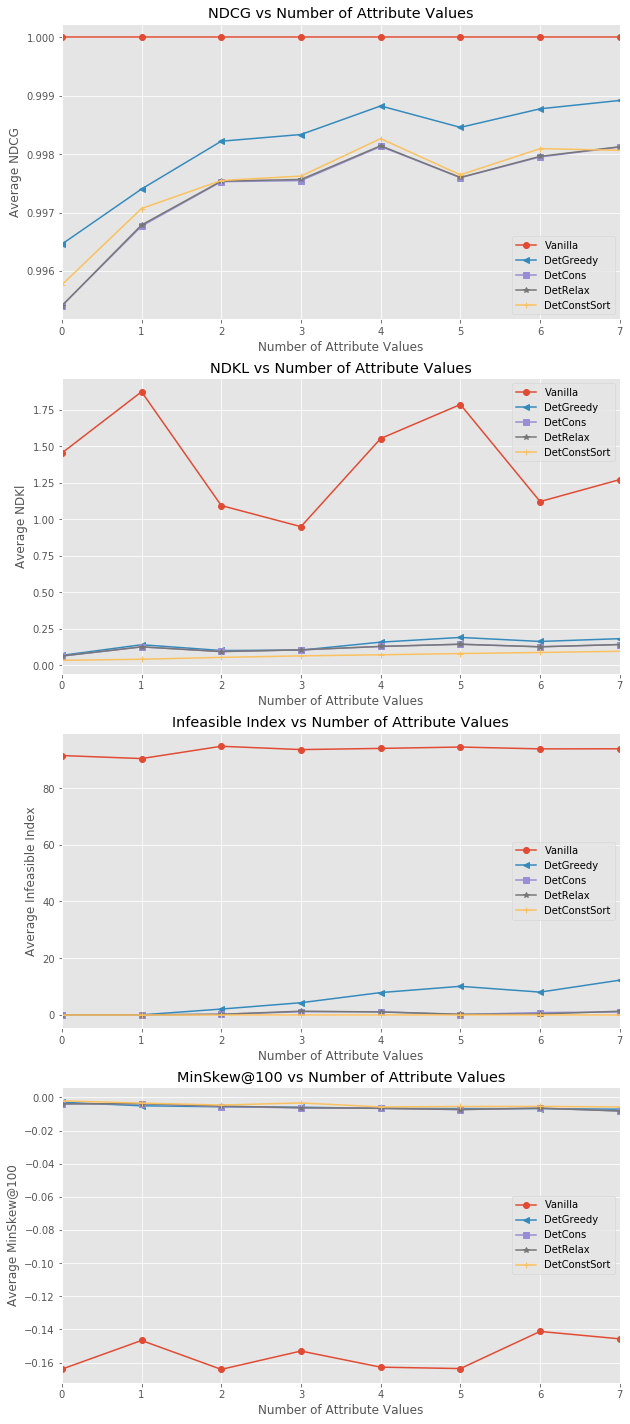

In [16]:
plt.style.use('ggplot')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(10,25))
    
pd.Series(ndcg_plot["vanilla"]).plot(label='Vanilla',style='-o',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetGreedy"]).plot(label='DetGreedy',style='-<',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetCons"]).plot(label='DetCons',style='-s',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetRelax"]).plot(label='DetRelax',style='-*',kind='line',ax=ax1)
pd.Series(ndcg_plot["DetConstSort"]).plot(label='DetConstSort',style='-+',kind='line',ax=ax1)
ax1.legend()
ax1.set_xlabel("Number of Attribute Values",)
ax1.set_ylabel("Average NDCG",)
ax1.set_title("NDCG vs Number of Attribute Values",)

pd.Series(ndkl_plot["vanilla"]).plot(label='Vanilla',style='-o',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetGreedy"]).plot(label='DetGreedy',style='-<',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetCons"]).plot(label='DetCons',style='-s',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetRelax"]).plot(label='DetRelax',style='-*',kind='line',ax=ax2)
pd.Series(ndkl_plot["DetConstSort"]).plot(label='DetConstSort',style='-+',kind='line',ax=ax2)
ax2.legend()
ax2.set_xlabel("Number of Attribute Values")
ax2.set_ylabel("Average NDKl")
ax2.set_title("NDKL vs Number of Attribute Values")

pd.Series(Inf_ind_plot["vanilla"]).plot(label='Vanilla',style='-o',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetGreedy"]).plot(label='DetGreedy',style='-<',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetCons"]).plot(label='DetCons',style='-s',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetRelax"]).plot(label='DetRelax',style='-*',kind='line',ax=ax3)
pd.Series(Inf_ind_plot["DetConstSort"]).plot(label='DetConstSort',style='-+',kind='line',ax=ax3)
ax3.legend()
ax3.set_xlabel("Number of Attribute Values")
ax3.set_ylabel("Average Infeasible Index")
ax3.set_title("Infeasible Index vs Number of Attribute Values")

pd.Series(Min_skew_plot["vanilla"]).plot(label='Vanilla',style='-o',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetGreedy"]).plot(label='DetGreedy',style='-<',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetCons"]).plot(label='DetCons',style='-s',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetRelax"]).plot(label='DetRelax',style='-*',kind='line',ax=ax4)
pd.Series(Min_skew_plot["DetConstSort"]).plot(label='DetConstSort',style='-+',kind='line',ax=ax4)
ax4.legend()
ax4.set_xlabel("Number of Attribute Values")
ax4.set_ylabel("Average MinSkew@100")
ax4.set_title("MinSkew@100 vs Number of Attribute Values")

plt.show()